defaultdict(<class 'list'>, {20000.0: [3.174512081, 2.515058922, 2.455848924, 2.60506551, 2.711076317], 15000.0: [8.67174562, 9.040387159, 2.705202852, 2.641986559, 3.091991556], 10000.0: [3.833659112, 3.592600763, 3.429961289, 3.482109913, 3.829394351], 5000.0: [5.066719185, 5.267864655, 5.007546329, 4.924405087, 5.038057255], 1000.0: [17.354870633, 17.823366289, 17.146860461, 17.278303797, 17.62067878]})
defaultdict(<class 'list'>, {20000.0: [1.5362139730000002, 1.5453824649999999, 1.558639386, 1.539779301, 1.530050948], 15000.0: [1.611149067, 1.574132957, 1.573655005, 1.564939632, 1.580196827], 10000.0: [2.255083735, 2.29492931, 2.2874048819999997, 2.298126568, 2.253352054], 5000.0: [3.763142651, 3.840510917, 3.8491801039999998, 3.7999390230000003, 3.8294479399999997], 1000.0: [15.953125568, 16.411127247000003, 16.621637841000002, 15.982852566000002, 15.90389481]})


/home/sthomas/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/sthomas/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/sthomas/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/sthomas/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/sthomas/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure i

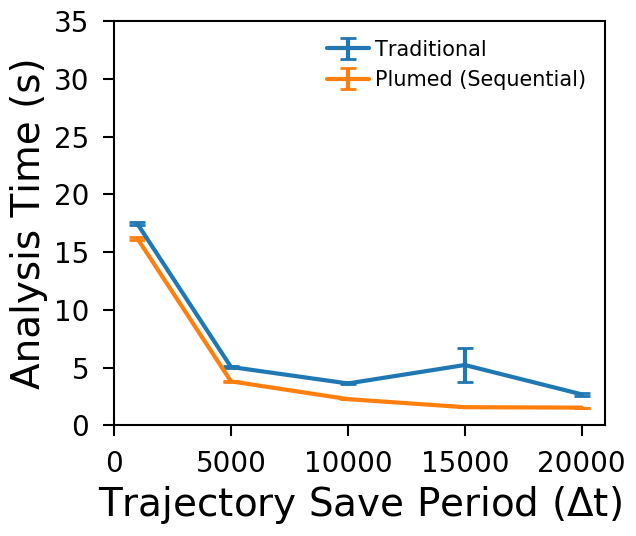

In [2]:
import numpy as np
import os
from glob import iglob
from collections import defaultdict
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats

def timestamp_to_seconds(t):
    return sum(float(n) * m for n, m in zip(reversed(t), (1, 60, 3600)))

# This will return absolute paths
paths = {'sequential_using_mdtraj':'Traditional','test_plumed':'Plumed (Sequential)'}
for path,legend in paths.items():
    total_times = defaultdict(list)
    analysis_times = defaultdict(list)
    sim_time_dict = defaultdict(list)
    log_files = [os.path.abspath(f) for f in iglob('{}/slurm*'.format(path), recursive=True)]
    for log_file in log_files:
        #print(log_file)
        total_time=None
        analysis_time=0
        dump_interval = None
        sim_times=[]
        with open(log_file) as fp:
            line = fp.readline()
            #print(line)
            while line:
                if 'DUMP_INTERVAL' in line:
                    values = line.split(':')
                    if float(values[1]) >500:
                        dump_interval = float(values[1])
                if 'Total wall time' in line:
                    values = line.split(':')
                    sim_time = float(timestamp_to_seconds(values[1:]))
                    sim_times.append(sim_time)
                if 'ANALYZE_TIME' in line:
                    #print(line)
                    values = line.split(':')
                    analysis_time = float(values[1])
                if 'ETE_TIME' in line:
                    values = line.split(':')
                    total_time = float(values[1])
                if 'DISPATCH_UPDATE_TIME_rank_0' in line:
                    values = line.split(':')
                    analysis_time += float(values[1])/1e3 # convert millisecond to second
                line = fp.readline()
            if analysis_time is not None and dump_interval is not None:
                analysis_times[dump_interval].append(analysis_time)
        if len(sim_times)>0 and dump_interval is not None:
            #print(log_file)
            sim_time_dict[dump_interval].append(sim_times[-1])
        else:
            #print('Could not find sim time in ',log_file)
            continue
    print(analysis_times)
    mean_tts = [np.mean(analysis_time_vals) for dump_interval, analysis_time_vals in analysis_times.items()]
    std_tts = [stats.sem(analysis_time_vals) for dump_interval, analysis_time_vals in analysis_times.items()]
    dump_intervals = analysis_times.keys()
    plt.errorbar(dump_intervals,mean_tts,std_tts, 
                 #fmt='o', 
                 #ecolor='g',
                 capsize=6, 
                 #elinewidth=3,
                 capthick=2,
                label=legend)
plt.xlabel("Trajectory Save Period ($\Delta$t)")
plt.ylabel("Analysis Time (s)")
plt.legend(fontsize=15)
plt.ylim(0,35)
plt.xlim(0,21000)
plt.savefig('figure_analysis_time.png', transparent=True)
plt.show()